In [57]:
import numpy as np
from pystrict import strict
from scipy.interpolate import interp1d
from scipy.integrate import solve_ivp
from scipy import constants
from PyMPDATA import (Solver, Stepper, Options, ScalarField, VectorField,
                      ExtrapolatedBoundaryCondition, ConstantBoundaryCondition)
from matplotlib import pyplot
from PyMPDATA_examples.utils.show_plot import show_plot

In [2]:
class arakawa_c:    
    def z_scalar_coord(grid):
        zZ = np.linspace(1/2, grid[-1]-1/2, grid[-1])
        return zZ

In [82]:
class MPDATA_1D:
    def __init__(self, nz, dt, advector_of_t, advectee_of_zZ_at_t0, g_factor_of_zZ, mpdata_settings):
        self.t = 0
        self.dt = dt
        self.advector_of_t = advector_of_t

        grid = (nz,)
        options = Options(
            n_iters=mpdata_settings['n_iters'],
            infinite_gauge=mpdata_settings['iga'],
            flux_corrected_transport=mpdata_settings['fct'],
            third_order_terms=mpdata_settings['tot']
        )
        stepper = Stepper(options=options, grid=grid, non_unit_g_factor=True)
        g_factor = ScalarField(
            data=g_factor_of_zZ(arakawa_c.z_scalar_coord(grid)),
            halo=options.n_halo,
            boundary_conditions=(ExtrapolatedBoundaryCondition(),)
        )
        advector = VectorField(
            data=(np.full(nz+1, advector_of_t(0)),),
            halo=options.n_halo,
            boundary_conditions=(ExtrapolatedBoundaryCondition(),)
        )
        data = advectee_of_zZ_at_t0(arakawa_c.z_scalar_coord(grid))
        self.advectee = ScalarField(
            data=data,
            halo=options.n_halo,
            boundary_conditions=(ConstantBoundaryCondition(data[0]),)
        )
        self.solver = Solver(stepper=stepper, advectee=self.advectee, advector=advector, g_factor=g_factor)

    def __call__(self):
        self.t += .5 * self.dt
        self.solver.advector.get_component(0)[:] = self.advector_of_t(self.t)
        self.solver.advance(1)
        self.t += .5 * self.dt


In [83]:
def convert_to(value, unit):
    value /= unit

class si:
    metres = 1
    m = 1
    s = 1
    hPa = 100
    minutes = 60
    km = 1000
    
class const:
    Mv = 0.018015
    Md = 0.028970
    eps = Mv / Md
    g = constants.g
    R_str = constants.R
    p1000 = 1000 * si.hPa
    Rd = 287.0027
    Rv = R_str / Mv
    c_pd = 1005
    c_pv = 1850
    lv = 2.5e6

In [84]:
class Formulae:
    @staticmethod
    def rho_d(p, qv, theta_std):
        return p * (1 - 1 / (1 + const.eps / qv)) / (np.power(p / const.p1000, const.Rd / const.c_pd) * const.Rd * theta_std)
    
    @staticmethod
    def drho_dz(g, p, T, qv, lv, dql_dz=0):
        Rq = const.Rv / (1 / qv + 1) + const.Rd / (1 + qv)
        cp = const.c_pv / (1 / qv + 1) + const.c_pd / (1 + qv)
        rho = p / Rq / T
        return (g / T * rho * (Rq / cp - 1) - p * lv / cp / T**2 * dql_dz) / Rq
    
    # A14 in libcloudph++ 1.0 paper
    @staticmethod
    def T(rhod, thd):
        return thd * np.power(rhod * thd / const.p1000 * const.Rd, const.Rd / const.c_pd / (1 - const.Rd / const.c_pd))

    # A15 in libcloudph++ 1.0 paper
    @staticmethod
    def p(rhod, T, qv):
        return rhod * (1 + qv) * (const.Rv / (1 / qv + 1) + const.Rd / (1 + qv)) * T
    
    @staticmethod
    def th_dry(th_std, qv):
        return th_std * np.power(1 + qv / const.eps, const.Rd / const.c_pd)


In [85]:
@strict
class Settings:
    def __init__(self, w_1: float):
        self.z_max = 3000 * si.metres
        self.t_max = 60 * si.minutes

        self.dz = 25*si.m
        self.dt = 1*si.s
        self.mpdata_settings = {'n_iters': 3, 'iga': True, 'fct': True, 'tot': True}
        self.qv = interp1d((0, 740, 3260), (.015, .0138, .0024))  
        self._th = interp1d((0, 740, 3260), (297.9, 297.9, 312.66))
        p0 = 975 * si.hPa  # note: not in the paper?
        self.rhod0 = Formulae.rho_d(p0, self.qv(0), self._th(0))
        self.thd = lambda z: Formulae.th_dry(self._th(z), self.qv(z))

        
        def drhod_dz(z, rhod):
            T = Formulae.T(rhod[0], self.thd(z))
            p = Formulae.p(rhod[0], T, self.qv(z))
            return Formulae.drho_dz(const.g, p, T, self.qv(z), const.lv)

        z_points = np.arange(0, self.z_max, self.dz / 2)
        rhod_solution = solve_ivp(
            fun=drhod_dz,
            t_span=(0, self.z_max),
            y0=np.asarray((self.rhod0,)),
            t_eval=z_points
        )
        assert rhod_solution.success
        
        self.rhod = interp1d(z_points, rhod_solution.y[0])
    
        t_1 = 600 * si.s
        self.w = lambda t: w_1 * np.sin(np.pi * t/t_1) if t < t_1 else 0

    
    @property
    def nz(self):
        nz = self.z_max / self.dz
        assert nz == int(nz)
        return int(nz)
    
    @property
    def nt(self):
        nt = self.t_max / self.dt
        assert nt == int(nt)
        return int(nt)


In [86]:
def plot(var, qlabel, fname, output):
    dt = output['t'][1] - output['t'][0]
    dz = output['z'][1] - output['z'][0]
    tgrid = np.concatenate(((output['t'][0] - dt / 2,), output['t'] + dt / 2))
    zgrid = np.concatenate(((output['z'][0] - dz / 2,), output['z'] + dz / 2))
    convert_to(zgrid, si.km)

    fig = pyplot.figure(constrained_layout=True)
    gs = fig.add_gridspec(25, 5)
    ax1 = fig.add_subplot(gs[:-1, 0:4])
    mesh = ax1.pcolormesh(tgrid, zgrid, output[var], cmap='twilight')

    ax1.set_xlabel('time [s]')
    ax1.set_ylabel('z [km]')

    cbar = fig.colorbar(mesh, fraction=.05, location='top')
    cbar.set_label(qlabel)

    ax2 = fig.add_subplot(gs[:-1, 4:], sharey=ax1)
    ax2.set_xlabel(qlabel)
    #ax2.set_yticks([], minor=False)

    last_t = 0
    for i, t in enumerate(output['t']):
        x, z = output[var][:, i], output['z'].copy()
        convert_to(z, si.km)
        params = {'color': 'black'}
        for line_t, line_s in {10: ':', 15: '--', 20: '-', 25: '-.'}.items():
            if last_t < line_t * si.minutes <= t:
                params['ls'] = line_s
                ax2.plot(x, z, **params)
                ax1.axvline(t, **params)
        last_t = t

    show_plot(filename=fname)


In [87]:
settings.nt, settings.nz

(3600, 120)

In [88]:
outputs = {}
for w in (2*si.m/si.s, 3*si.m/si.s):
    settings = Settings(w_1=w)
    
    mpdata = MPDATA_1D(nz=settings.nz, dt=settings.dt, mpdata_settings=settings.mpdata_settings,
                   advector_of_t=lambda t: settings.w(t) * settings.dt / settings.dz,
                   advectee_of_zZ_at_t0=lambda zZ: settings.qv(zZ*settings.dz),
                   g_factor_of_zZ=lambda zZ: settings.rhod(zZ*settings.dz))
    
    output = {k: np.zeros((settings.nz, settings.nt+1)) for k in ('psi',)}
    assert 't' not in output and 'z' not in output
    output['t'] = np.linspace(0, settings.nt*settings.dt, settings.nt+1, endpoint=True)
    output['z'] = np.linspace(settings.dz/2, (settings.nz-1/2)*settings.dz, settings.nz, endpoint=True)
    
    output['psi'][:,0] = mpdata.advectee.get()
    for t in range(settings.nt):
        mpdata()
        output['psi'][:,t+1] = mpdata.advectee.get()

    key = f"w={w}"
    outputs[key] = output

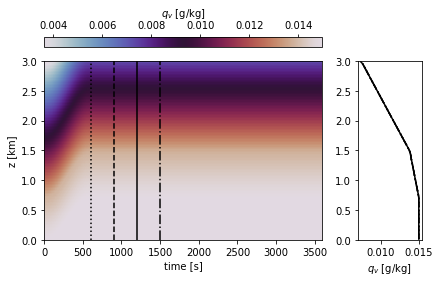

HTML(value="<a href='./qv_w=2.pdf' target='_blank'>./qv_w=2.pdf</a><br>")

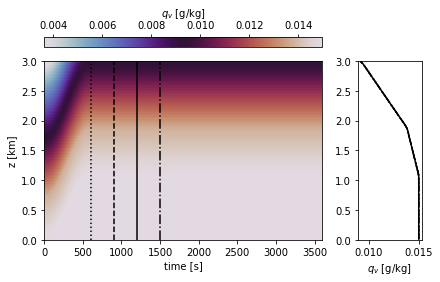

HTML(value="<a href='./qv_w=3.pdf' target='_blank'>./qv_w=3.pdf</a><br>")

In [89]:
for w in (2, 3):
    plot(var='psi', qlabel='$q_v$ [g/kg]', fname=f'qv_w={w}.pdf', output=outputs[f'w={w}.0'])